# NOT USED — accross channel is using index not distance

# Interpolate bed surface using my line2line method with spline 

NB. removed  'lineback2camp' as the spline looked crazy





In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed_depth.shp')

In [3]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    
def add_dDELAYdx(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dDELAY' and 'dDELAYdx' to the geodataframe
    """
    
    gdf['dDELAY'] = gdf.DELAY.diff().copy()
        
    gdf['dDELAYdx'] = gdf.dDELAY.to_numpy()/gdf.dx.to_numpy()

In [4]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2, ie one gdf for each line.

for line in bed_gdf[bed_gdf.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].copy()
    ll[line].sort_values(by='x',inplace=True)
    ll[line].reset_index(drop=True,inplace=True)
    add_distance_to_gdf(ll[line])
    add_dDELAYdx(ll[line])
    

In [5]:
cross_channel_lines = [ 'line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4']

In [6]:
#lines which cross the channel, (ll restricted to the above subset)
cl  = {key:ll[key] for key in cross_channel_lines}

In [7]:
#channel mins is the same method as in 11_RADAR_profile_possible_channel_locs.ipynb
#its checked there
channel_mins = {key:value.ice_thickn.idxmin() for key,value in cl.items()}

### next do channel edges

In [8]:
# find the point at the edge of each channel, where dDELAYdx is over a certain threshold
channel_edges = {}
for key,value in cl.items():
    channel_edges[key] = [value[abs(value.dDELAYdx) > 20].index[0],
                          value[abs(value.dDELAYdx) > 20].index[-1]] 

In [9]:
channel_edges

{'line7p75': [115, 149],
 'line7p5': [101, 168],
 'line7p25': [148, 214],
 'line7': [303, 356],
 'line6': [545, 684],
 'line5': [631, 813],
 'lineAPREScross': [416, 648],
 'line4': [711, 869]}

In [10]:
# add 'normalised_dist_from_centre_chan' to cl dataframe

chanpts = {} #left right and mid indexs of points of channel

for key,value in cl.items():
    
    ineg1, ipos1 = channel_edges[key] 
    i0 = channel_mins[key]
    
    chanpts[key] = [ineg1, i0, ipos1]
    
    lhs_chann = np.linspace(-1,0,i0 - ineg1 + 1) #left and including mid of channel
    rhs_chann = np.linspace(0,1,ipos1 - i0 + 1)[1:] #right, not including mid of channel
    value['normalised_dist_from_centre_chan'] = np.nan
    value.normalised_dist_from_centre_chan.iloc[ineg1:ipos1 + 1] = np.hstack([lhs_chann,rhs_chann])    
    
    del lhs_chann, rhs_chann, ineg1, ipos1, i0

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


 # bin over each 5m is easier than interpolating 
 
 - Use a new coordinate system where 0 is middle of channel -1 is the left of the channel 1 is the right of the channel (or maybe l & r opposite)
 
  

In [11]:
def bin_chan(gdf):
    """
    Input: Gdf with 'normalised_dist_from_centre_chan' as a column
    
    bin the ice thickness & coordinates in the channel
    
    Output: gdf only over the channel, all variables binned to certain cross channel intervals
    """
    
    bin_size = 0.1 # the channel is 2 units wide. so 0.1 means 20 points accross the channel

    L= 2 #length of line (rounds up to bin size)

    ir = pd.interval_range(-1,1,periods=20) # bin sections

    bins = pd.cut( gdf.normalised_dist_from_centre_chan , bins=ir) #corresponding bins for each point

    bins.rename('channel_bins',inplace=True)

    gdf_out = gdf.groupby(bins).mean().copy()  #average each bin
    gdf_out.reset_index(inplace=True)
    gdf_out['line_name'] = gdf.line_name.iloc[0]

    geometry = [Point(xy) for xy in zip(gdf_out.x,gdf_out.y)]
    gdf_out = gpd.GeoDataFrame(gdf_out,geometry=geometry,crs="EPSG:3031")
    gdf_out['index_over_chan'] = np.linspace(-1,0.9,20).round(decimals = 1)
#     gdf_out.set_index('index_over_chan',inplace=True)
    
    return gdf_out

In [12]:
#for every cross channel line, bin the indicies in the channel

c_grid = {}

for key,value in cl.items():
    c_grid[key] = bin_chan(value)


In [13]:
#vertical slice ( a column) is over one radar line
index_over_chan = np.array([value.index_over_chan.tolist() for value in c_grid.values()]).T
ice_thickn = np.array([value.ice_thickn.tolist() for value in c_grid.values()]).T
points_x = np.array([value.x for value in c_grid.values()]).T
points_y = np.array([value.y for value in c_grid.values()]).T
#[line[0] for line in points] gets one point from each for points

# Now do 1D spline interpolation of the channel, one variable at a time

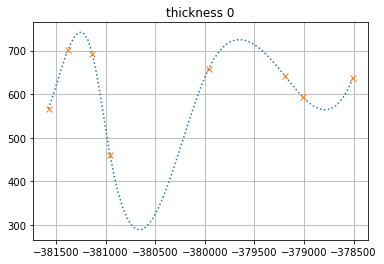

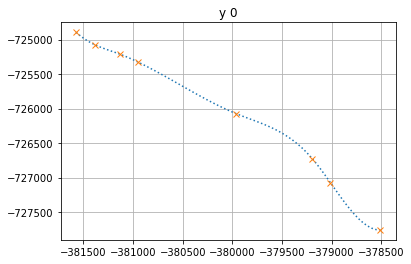

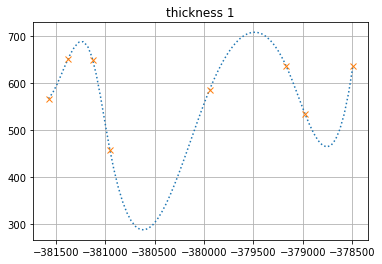

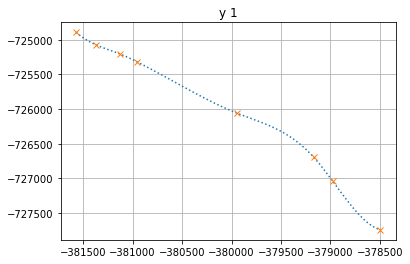

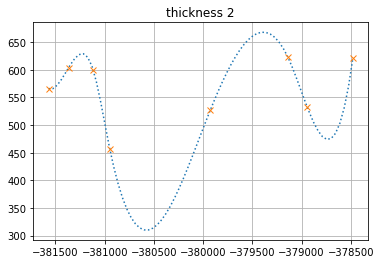

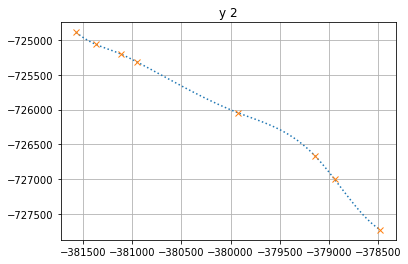

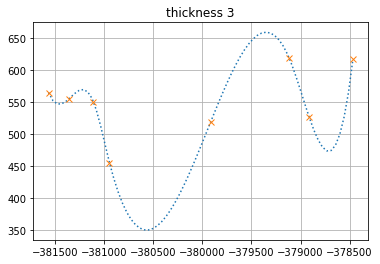

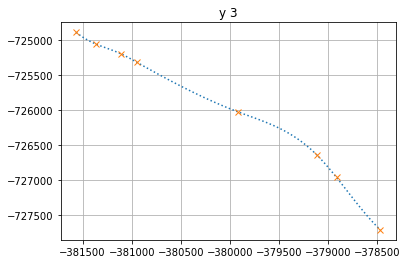

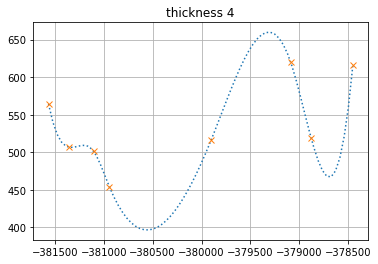

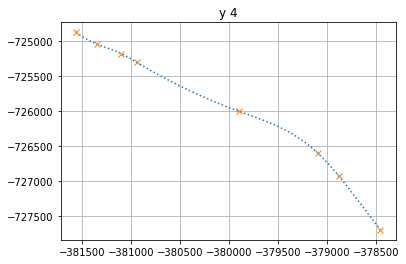

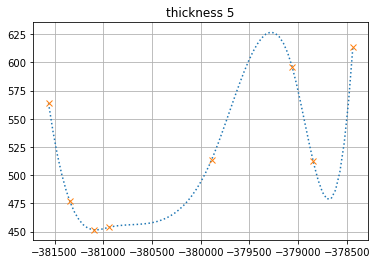

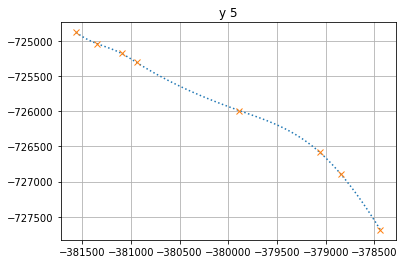

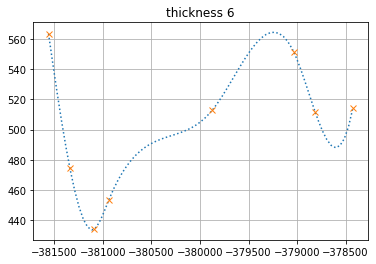

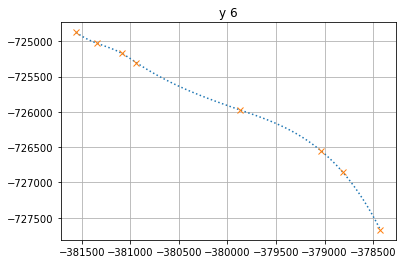

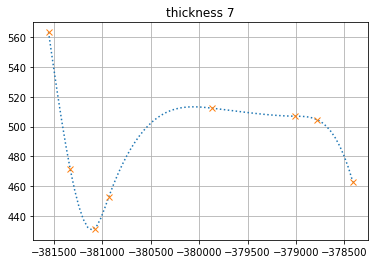

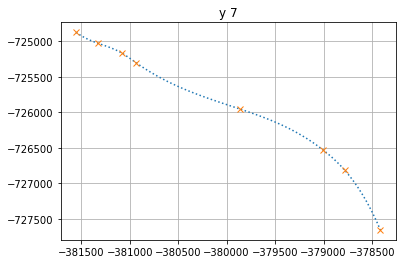

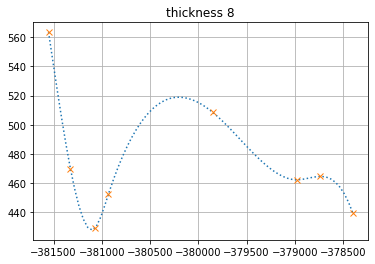

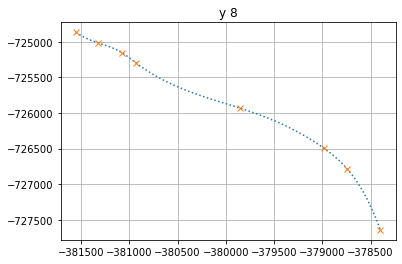

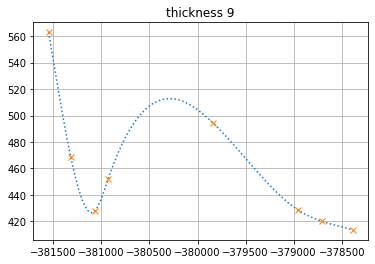

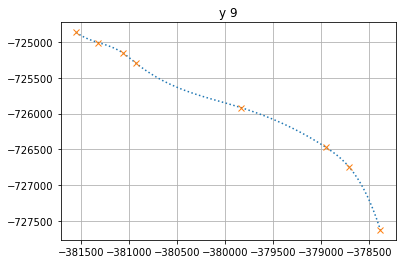

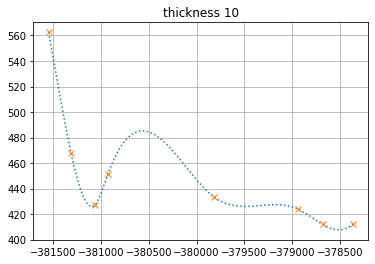

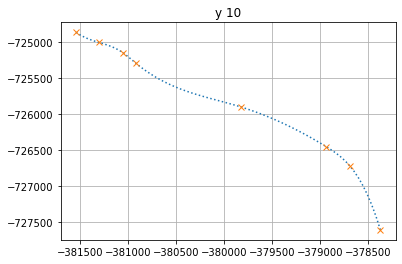

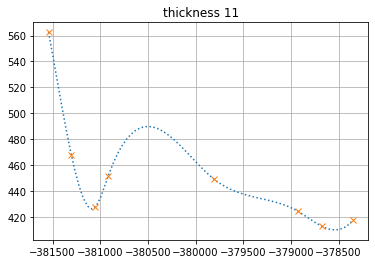

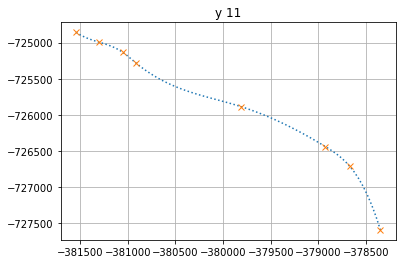

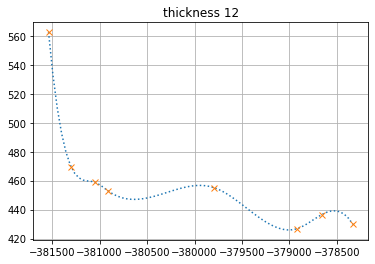

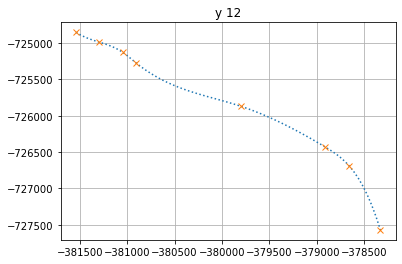

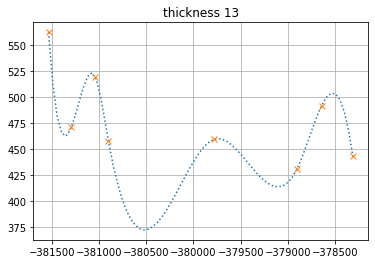

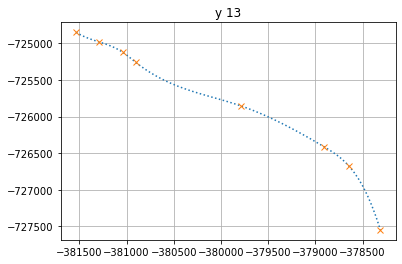

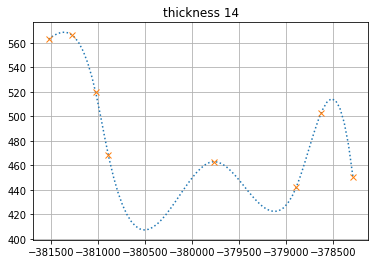

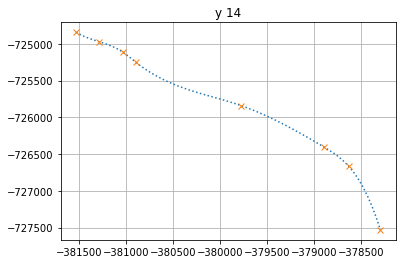

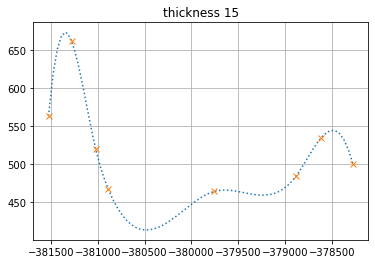

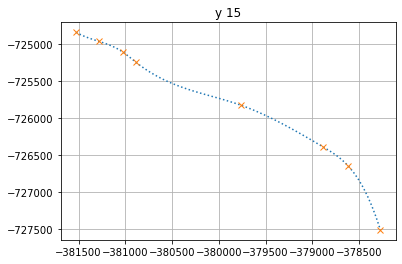

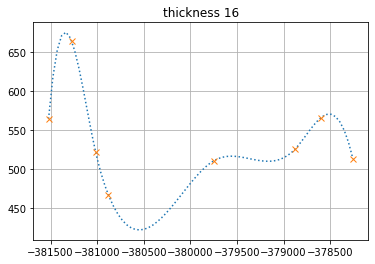

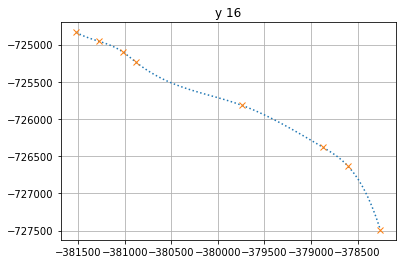

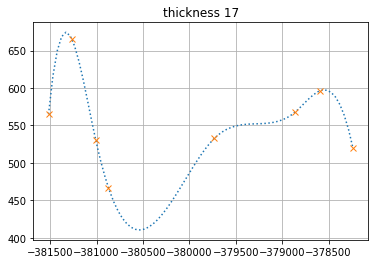

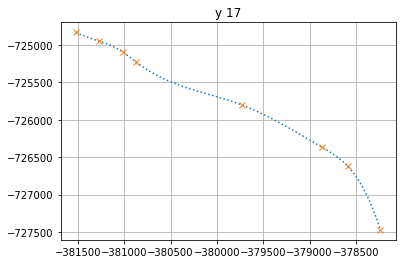

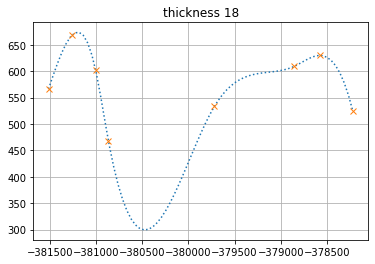

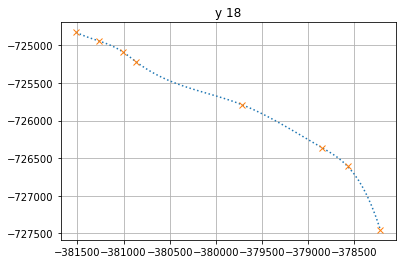

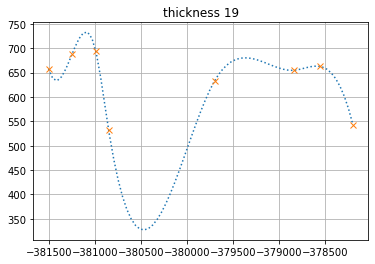

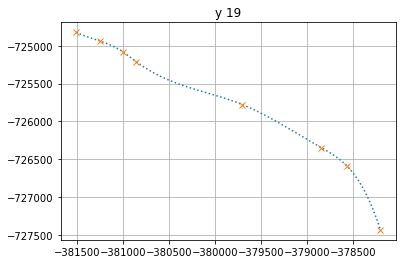

In [193]:
number_of_new_points = 9 # number_of_new_points to interpolate between existing points
new_length =  number_of_new_points*(points_x.shape[1]-1)+points_x.shape[1]  
ice_thickn_new = np.zeros([ice_thickn.shape[0], new_length])
points_x_new = ice_thickn_new.copy()
points_y_new = ice_thickn_new.copy()

for i in range(points_x.shape[0]):

    x = points_x[i,:]
    y = points_y[i,:]
    z = ice_thickn[i,:]

    # y_func = sp.interpolate.make_interp_spline(x, y)
    # z_func =sp.interpolate.make_interp_spline(x, z)
    x_new = np.linspace(points_x[i,:][0],points_x[i,:][-1],new_length)
    
    y_tck = sp.interpolate.splrep(x, y)
    z_tck = sp.interpolate.splrep(x, z)
#     z_tck = sp.interpolate.splrep(x, z,k=2,s=4000)
    
    y_new = sp.interpolate.splev(x_new, y_tck, der=0)
    z_new = sp.interpolate.splev(x_new, z_tck, der=0)
    
    points_x_new[i,:] = x_new
    points_y_new[i,:] = y_new
    ice_thickn_new[i,:] = z_new
    
    plt.figure()
    plt.plot(x_new,z_new,':')
    plt.plot(x,z,'x')
    plt.grid()
    plt.title(f'thickness {i}')
    plt.show()
    
    plt.figure()
    plt.plot(x_new,y_new,':')
    plt.plot(x,y,'x')
    plt.grid()
    plt.title(f'y {i}')
    plt.show()

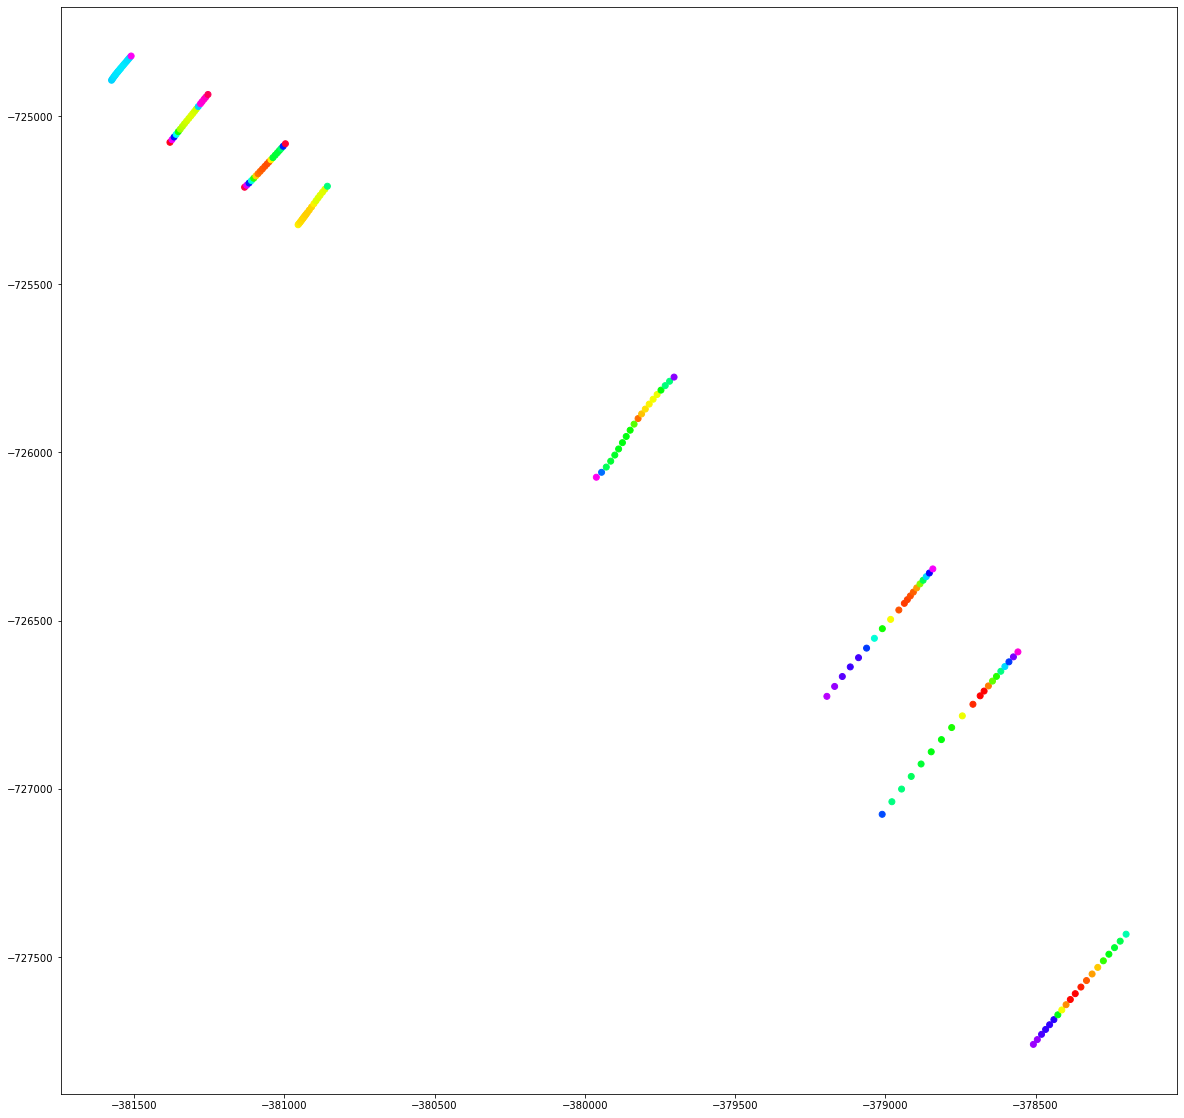

In [196]:
plt.figure(figsize=(20,20))
plt.scatter(points_x,points_y,c=ice_thickn,cmap='hsv')

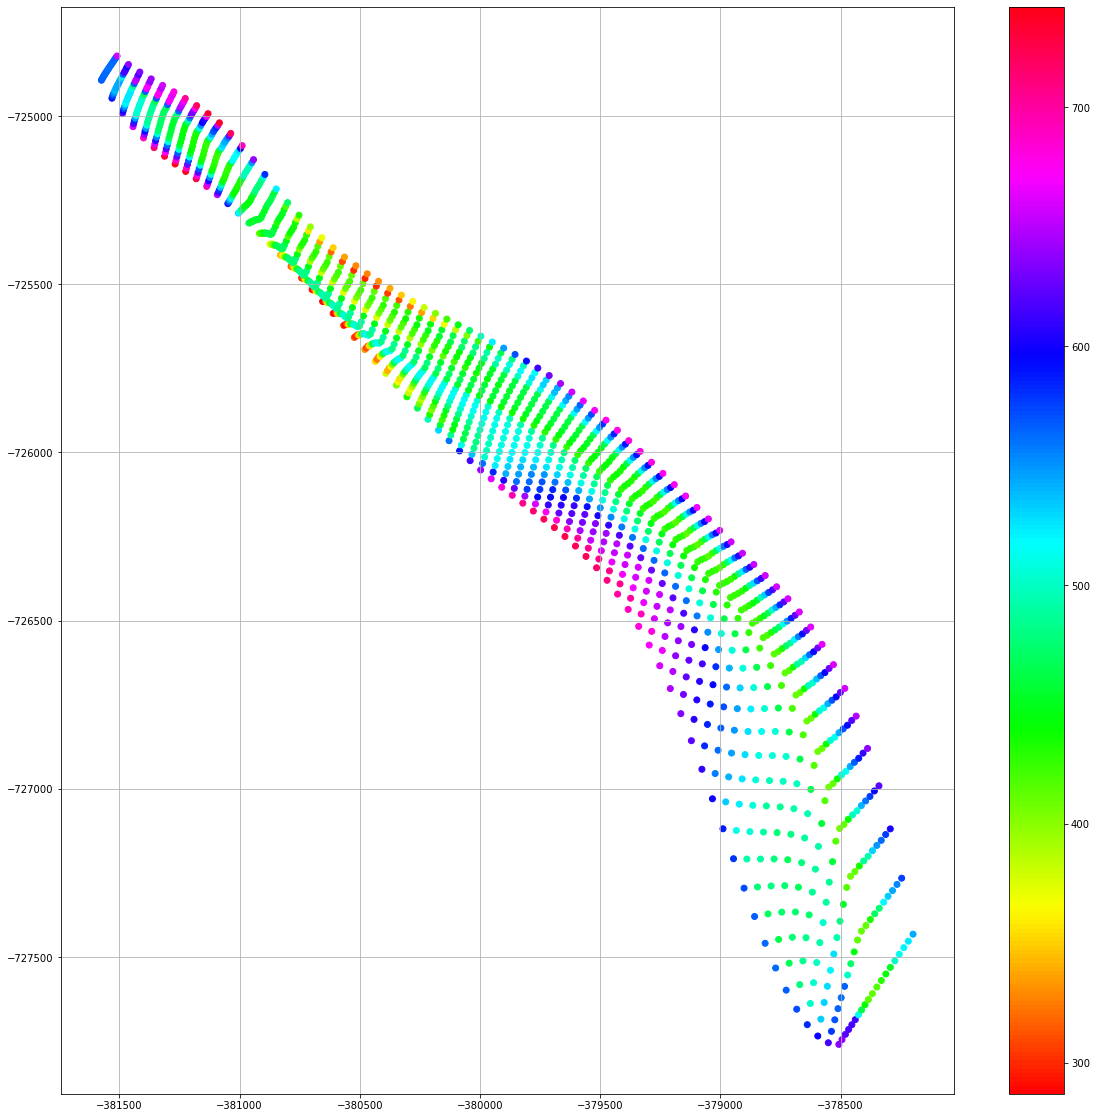

In [198]:
plt.figure(figsize=(20,20))
plt.scatter(points_x_new,points_y_new,c=ice_thickn_new,cmap='hsv')
plt.colorbar()
plt.grid()

In [199]:
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()

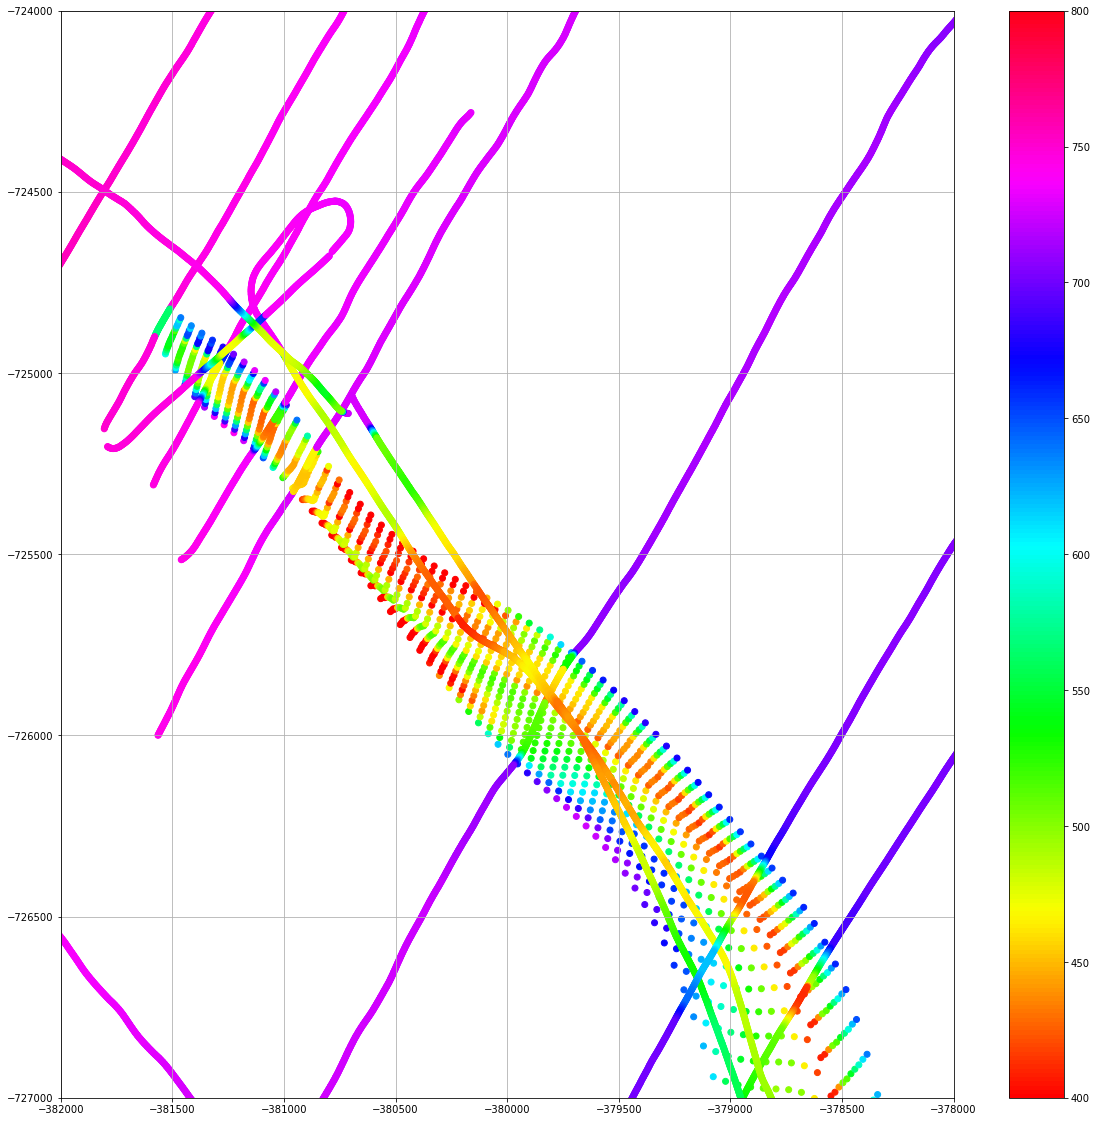

In [200]:
plt.figure(figsize=(20,20))
plt.scatter(points_x_new,points_y_new,c=ice_thickn_new,cmap='hsv',vmin=400, vmax=800)
plt.scatter(gdf.x,gdf.y,c=gdf.ice_thickn,cmap='hsv',vmin=400, vmax=800)
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.colorbar()
plt.grid()

In [201]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_spline_points_x.npy',points_x_new)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_spline_points_y.npy',points_y_new)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2lineinterp_spline_ice_thickn.npy',ice_thickn_new)

# Conclusion

### The good

While the spline interpolation looks like it goes too thin between line 6 and 7, it acutually lines up with the down channel lines, i think its real

### The bad

connecting points from left to right in the channel leaves some crazy results, see below, the channel is reverse shaped, with two incisions

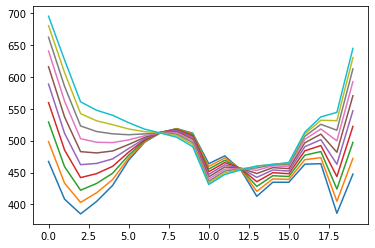

In [212]:
for i in range(10):
    plt.plot(ice_thickn_new[:,30+i])

In the next notebook 15_ I will just do centreline and edges, ie not bits between